2 a)

$$\frac{p(y=1|x)}{p(t=1|x)}=\frac{p(y=1,x)/p(x)}{p(t=1,x)/p(x)}=\frac{p(y=1,x)}{p(t=1,x)}=\frac{p(t=1,y=1,x)}{p(t=1,x)}=p(y=1|t=1,x)=p(y=1|t=1).$$

2 b)

$h(x)=p(y=1|x)=\alpha\cdot p(t=1|x)\approx \alpha$ assuming $p(t=1|x)\approx 1$ in $V^+$.


2 c)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[-0.97114015  2.73208733  1.07403466]
[-2.91607463  0.78596503  0.09282843]
2.0609416939522394
12.0
0.1717451411626866
[-0.55096911  0.78596503  0.09282843]


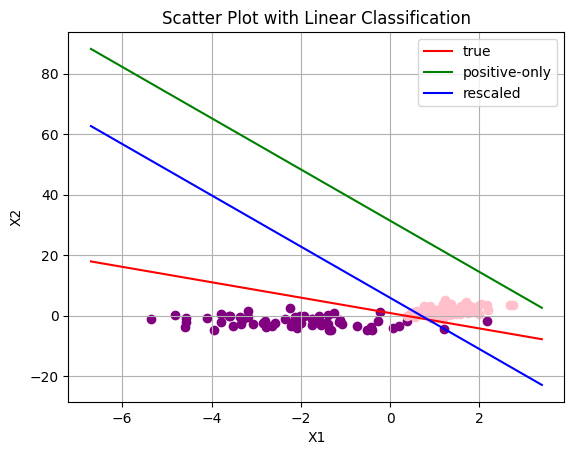

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/cs229/problem-sets/PS1/src') # Python interpreter searches for modules/packages to import from a list of directories called 'PYTHONPATH', which is added to here
import util # import the entire '.py' file, executing any top-level code, and copying all functions, variables, and classes
from linear_model import LinearModel
sys.path.remove('/content/drive/MyDrive/cs229/problem-sets/PS1/src')  # remove added path from 'PYTHONPATH'


# manually import 'LogisticRegression'
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        m, n = x.shape
        self.theta = np.zeros(n)
        gradient = np.zeros(n)
        hessian = np.zeros((n, n))
        update = np.ones(n)
        while np.linalg.norm(update, 1) > 1e-5:
          for i in range(m):
            gradient += x[i] * (y[i] - 1 / (1 + np.exp(-np.dot(x[i], self.theta))))
            hessian += np.outer(x[i], x[i]) * 1/(1 + np.exp(-np.dot(x[i], self.theta))) * (np.exp(-np.dot(x[i], self.theta)/(1 + np.exp(-np.dot(x[i], self.theta)))))
          gradient = - gradient / m
          hessian = hessian / m
          inverse_hessian = np.linalg.inv(hessian)
          update = np.dot(inverse_hessian, gradient)
          self.theta = self.theta - update
        return self.theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.
        Args:
            x: Inputs of shape (m, n).
        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return np.dot(x, self.theta) >= 0
        # *** END CODE HERE ***


# Character to replace with sub-problem letter in plot_path/pred_path
WILDCARD = 'X'


def main(train_path, valid_path, test_path, pred_path):
    """Problem 2: Logistic regression for incomplete, positive-only labels.
    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.
    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')
    # *** START CODE HERE ***
    # Part (c): Train and test on true labels
    # Make sure to save outputs to pred_path_c
    x_train, y_train = util.load_dataset(train_path, label_col='t', add_intercept=True)
    logistic_regression = LogisticRegression()
    theta_c = logistic_regression.fit(x_train, y_train)
    x_test, y_test = util.load_dataset(test_path, label_col='t', add_intercept=True)
    y_pred = logistic_regression.predict(x_test)
    np.savetxt(pred_path_c, y_pred, delimiter=',', fmt='%d')
    # Part (d): Train on y-labels and test on true labels
    # Make sure to save outputs to pred_path_d
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    logistic_regression_pos = LogisticRegression()
    theta_d = logistic_regression_pos.fit(x_train, y_train)
    y_pred = logistic_regression_pos.predict(x_test)
    np.savetxt(pred_path_d, y_pred, delimiter=',', fmt='%d')
    # Part (e): Apply correction factor using validation set and test on true labels
    # Plot and use np.savetxt to save outputs to pred_path_e
    x_valid, y_valid = util.load_dataset(valid_path, add_intercept=True)
    y_pred = logistic_regression_pos.predict(x_valid)
    prob = 1/(1 + np.exp(- np.dot(x_valid, theta_d)))
    alpha = np.sum(prob * y_valid) / np.sum(y_valid)
    y_pred = np.dot(x_test, theta_d) >= - np.log (2 / alpha - 1) # $p/\alpha\geq 0.5$, $p\geq 0.5\alpha$, $1/(1+e^{-z})\geq 0.5\alpha$, $2/\alpha\geq 1+e^{-z}$, $e^{-z}\leq 2/\alpha-1$, $-z\leq \log(2/\alpha-1)$, $z\geq -\log(2/\alpha-1)$
    np.savetxt(pred_path_e, y_pred, delimiter=',', fmt='%d')
    # draw graph
    import matplotlib.pyplot as plt
    for i in range(len(x_test)):
        if y_test[i] == 0:
            plt.scatter(x_test[i, 1], x_test[i, 2], color='purple')  # Points where t is 0
        else:
            plt.scatter(x_test[i, 1], x_test[i, 2], color='pink')  # Points where t is 1
    # Calculate $m_i$ and $c_i$ for $y = m_i * x + c_i$ from $\theta_0 + \theta_1 x_1 + \theta_2 x_2=0$
    c_1 = - theta_c[0] / theta_c[2]
    m_1 = - theta_c[1] / theta_c[2]
    c_2 = - theta_d[0] / theta_d[2]
    m_2 = - theta_d[1] / theta_d[2]
    # calculate $m_i$ and $c_i$ for $y = m_i * x + c_i$ from $\theta_0 + \theta_1 x_1 + \theta_2 x_2 = -\log(2/alpha - 1)$
    c_3 = - (theta_d[0] + np.log(2 / alpha - 1)) / theta_d[2]
    print(alpha)
    print(theta_d + np.log(2 / alpha - 1) * np.array([1,0,0]))
    m_3 = - theta_d[1] / theta_d[2]
    # Generate and plot line 1
    x_values = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 100)
    y_values = m_1 * x_values + c_1
    plt.plot(x_values, y_values, '-r', label='true')
    # Generate and plot line 2
    x_values = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 100)
    y_values = m_2 * x_values + c_2
    plt.plot(x_values, y_values, '-g', label='positive-only')
    # Generate and plot line 3
    x_values = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 100)
    y_values = m_3 * x_values + c_3
    plt.plot(x_values, y_values, '-b', label='rescaled')
    # Add details and show plot
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Scatter Plot with Linear Classification')
    plt.legend()
    plt.grid(True)
    plt.show()
    # *** END CODER HERE


if __name__ == '__main__':
  train_path = '/content/drive/MyDrive/cs229/problem-sets/PS1/data/ds3_train.csv'
  valid_path = '/content/drive/MyDrive/cs229/problem-sets/PS1/data/ds3_valid.csv'
  test_path = '/content/drive/MyDrive/cs229/problem-sets/PS1/data/ds3_test.csv'
  pred_path = '/content/drive/MyDrive/cs229/problem-sets/PS1/data/ds3_pred_X.csv'
  main(train_path, valid_path, test_path, pred_path)